<div style="background: linear-gradient(-45deg, #B7B597, #6B8A7A); padding: 32px; text-align: center; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); margin-bottom: 24px;">
    <h1 style="color: white; font-family: 'Arial', sans-serif; font-size: 36px; margin: 0; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
        Face Mask Detection Project
    </h1>
</div>


<h3>Importing Packages ⬇️</h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import argparse
import os
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

<h3>Loading and Preprocessing Images ⬇️</h3>

In [2]:
print("Loading images...")
imagePaths = list(paths.list_images('./dataset'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

Loading images...


<h3>Converting Data and Labels to NumPy Arrays ⬇️</h3>

In [3]:
data = np.array(data, dtype='float32')
labels = np.array(labels)


In [4]:
data

array([[[[-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         ...,
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.84313726, -0.8980392 , -0.77254903]],

        [[-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         ...,
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.75686276, -0.7882353 , -0.67058825]],

        [[-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         ...,
         [-0.88235295, -0.8980392 , -0.7882353 ],
         [-0.8666667 , -0.88235295, -0.77254903],
         [-0.85882354, -0.8745098 , -0.7647059 ]],

        ...,

        [[ 0.3803922 , -0.9607843 , -0

In [5]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

<h3>Binarizing and One-Hot Encoding Labels ⬇️</h3>

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

<h3>Splitting Data into Training and Testing Sets ⬇️</h3>

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=50)

<h3>Image Data Augmentation ⬇️</h3>

In [8]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [9]:
import gc
del(data)
del(labels)
gc.collect()

0

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

<h3>Adding Custom Layers to Model Head ⬇️</h3>

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

<h3>Constructing Final Model with Custom Head ⬇️</h3>

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel)

<h3>Freezing Base Model Layers ⬇️</h3>

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

<h3>Compiling the Model with Adam Optimizer ⬇️</h3>

In [14]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

opt = Adam(learning_rate=0.0001, decay=0.0001 / 20)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

<h3>Training the Model with Data Augmentation ⬇️</h3>

In [16]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=20),
    steps_per_epoch=len(trainX) // 20,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 20,
    epochs=20
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 574ms/step - accuracy: 0.9613 - loss: 0.1535 - val_accuracy: 0.9731 - val_loss: 0.0838
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 1.0000 - loss: 0.0597 - val_accuracy: 0.9731 - val_loss: 0.0836
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 598ms/step - accuracy: 0.9751 - loss: 0.0870 - val_accuracy: 0.9829 - val_loss: 0.0640
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9500 - loss: 0.1062 - val_accuracy: 0.9829 - val_loss: 0.0639
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 579ms/step - accuracy: 0.9781 - loss: 0.0753 - val_accuracy: 0.9817 - val_loss: 0.0563
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.9817 - val_loss: 0.0563
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 577ms/step - accuracy: 0.9835 - loss: 0.0643 - val_accuracy: 0.9768 - val_loss: 0.0585
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 1.0000 - loss: 0.04

<h3>Save Model ⬇️</h3>

In [ ]:
model.save('trained_model.h5', save_format="h5")

<h3>Test Model ⬇️</h3>

In [2]:
print("Loading face detector model...")

prototxtPath = os.path.sep.join(['FaceDetector', 'deploy.prototxt'])
weightsPath = os.path.sep.join(['FaceDetector', 'res10_300x300_ssd_iter_140000.caffemodel'])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model('trained_model.h5')
image = cv2.imread('testImages/test4.jpg')
orig = image.copy()
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
print("Computing face detections...")
net.setInput(blob)
detections = net.forward()

Loading face detector model...


Computing face detections...


In [3]:
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence >= 0.6:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


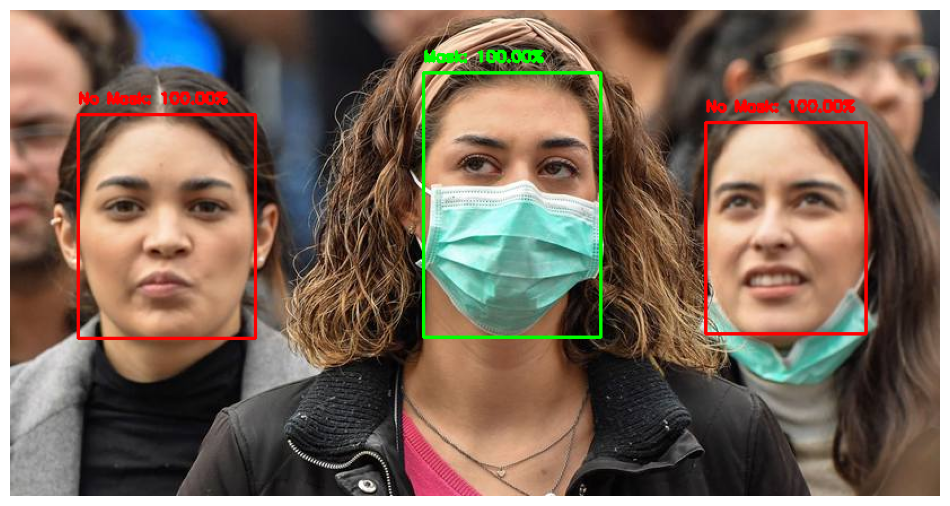

In [4]:
plt.figure(figsize=(12, 8)) 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()